https://towardsdatascience.com/variational-inference-with-normalizing-flows-on-mnist-9258bbcf8810

In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from matplotlib import collections  as mc
from typing import List
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import Dataset
from torch import optim
from torch.nn import BCEWithLogitsLoss

In [5]:
def tanh_prime(x):
    return 1 - torch.tanh(x) ** 2

In [19]:
class BinarizedMNIST(Dataset):
    def __init__(self, file):
        self.data = np.load(file)
        self.data = torch.tensor(self.data)

    def __len__(self,):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [45]:
class PlanarFlow(nn.Module):
    def __init__(self, D, activation=torch.tanh):
        super().__init__()
        self.D = D
        self.w = nn.Parameter(torch.empty(D))
        self.b = nn.Parameter(torch.empty(1))
        self.u = nn.Parameter(torch.empty(D))
        self.activation = activation
        self.activation_derivative = tanh_prime if activation == torch.tanh else NotImplemented

        nn.init.normal_(self.w)
        nn.init.normal_(self.u)
        nn.init.normal_(self.b)

    def forward(self, z: torch.Tensor):
        lin = (z @ self.w + self.b).unsqueeze(1)  # shape: (B, 1)
        f = z + self.u * self.activation(lin)  # shape: (B, D)
        phi = self.activation_derivative(lin) * self.w  # shape: (B, D)
        log_det = torch.log(torch.abs(1 + phi @ self.u) + 1e-4) # shape: (B,)
        

        return f, log_det

In [14]:
class FCNEncoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        
        hidden_sizes = [dim_input] + hidden_sizes
        
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

        
    def forward(self, x):
        return self.net(x)

In [15]:
class FlowModel(nn.Module):
    def __init__(self, flows: List[str], D: int, activation=torch.tanh):
        super().__init__()
        
        self.prior = MultivariateNormal(torch.zeros(D), torch.eye(D))
        self.net = []

        for i in range(len(flows)):
            layer_class = eval(flows[i])
            self.net.append(layer_class(D, activation))

        self.net = nn.Sequential(*self.net)

        self.D = D


    def forward(self, mu: torch.Tensor, log_sigma: torch.Tensor):
        """
        mu: tensor with shape (batch_size, D)
        sigma: tensor with shape (batch_size, D)
        """
        sigma = torch.exp(log_sigma)
        batch_size = mu.shape[0]
        samples = self.prior.sample(torch.Size([batch_size]))
        z = samples * sigma + mu

        z0 = z.clone().detach()
        log_prob_z0 = torch.sum(
            -0.5 * torch.log(torch.tensor(2 * math.pi)) - 
            log_sigma - 0.5 * ((z - mu) / sigma) ** 2, 
            axis=1)
        
        log_det = torch.zeros((batch_size,))
        
        for layer in self.net:
            z, ld = layer(z)
            log_det += ld

        log_prob_zk = torch.sum(
            -0.5 * (torch.log(torch.tensor(2 * math.pi)) + z ** 2), 
            axis=1)

        return z, log_prob_z0, log_prob_zk, log_det

In [17]:
class FCNDecoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], dim_input: int, activation=nn.ReLU()):
        super().__init__()
        
        hidden_sizes = [dim_input] + hidden_sizes
        self.net = []

        for i in range(len(hidden_sizes) - 1):
            self.net.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.net.append(nn.ReLU())
        
        self.net = nn.Sequential(*self.net)

    def forward(self, z: torch.Tensor):
        return self.net(z)

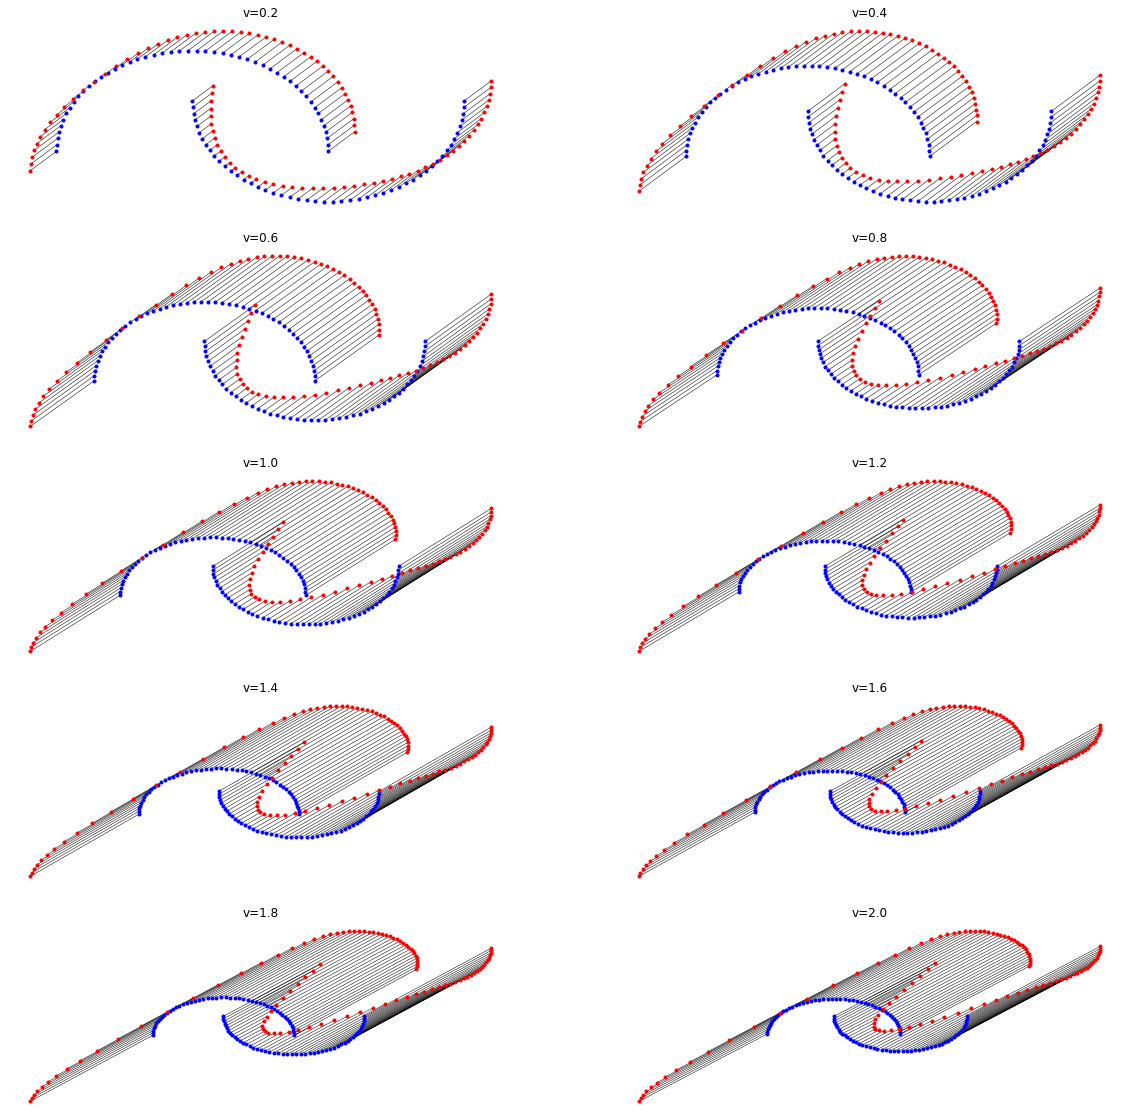

In [11]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

q0, _ = make_moons(n_samples=100)

w = np.ones((2,)) * 2.
b = np.zeros((1,))

for i, v in enumerate(np.linspace(0.2, 2., 10)):
    u = np.ones((2,)) * v
    lin = (q0 @ w + b)[:, np.newaxis]
    q1 = q0 + u * np.tanh(lin)

    axes[i//2, i%2].plot(q0[:, 0], q0[:, 1], '.', color='blue');
    axes[i//2, i%2].axis('off');
    axes[i//2, i%2].plot(q1[:, 0], q1[:, 1], '.', color='red');
    axes[i//2, i%2].set_title('v=%.1f' % v)

    lines = [[q0[i], q1[i]] for i in range(100)]
    lc = mc.LineCollection(lines, colors='black', linewidths=0.5)
    axes[i//2, i%2].add_collection(lc)

In [56]:
# import tensorflow_datasets as tfds
# from tqdm import tqdm
# ds = tfds.load('binarized_mnist', split='train', shuffle_files=True)

# np_images = []

# for example in tqdm(ds, total=len(ds)):
#     image = example["image"]
#     np_images.append(image.numpy().reshape(1, 28, 28))
    
# np_images = np.concatenate(np_images, axis=0)
# np.save('bin_mnist.npy', np_images)

In [37]:
# np.save('bin_mnist.npy', np_images)

In [41]:
np_images = np.load('bin_mnist.npy')

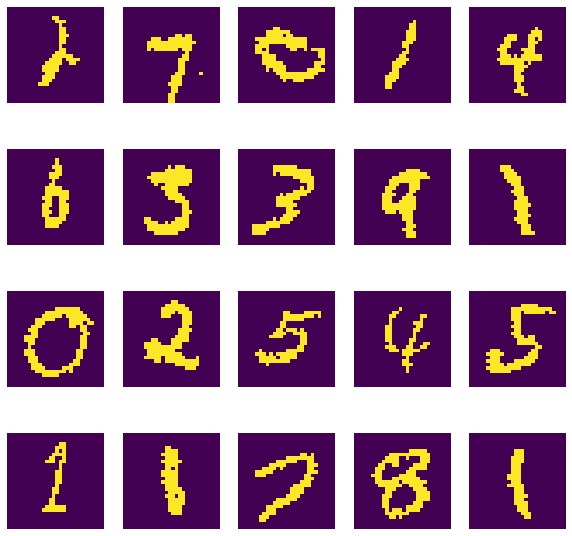

In [42]:
fig, axs = plt.subplots(4, 5, figsize=(10, 10))

for i in range(20):
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].imshow(np_images[i])
    
plt.savefig('bin-mnist.png')

In [43]:
mnist_data = BinarizedMNIST('bin_mnist.npy')
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)

In [53]:
D = 40

encoder = FCNEncoder(hidden_sizes=[128, 64, 2*D], dim_input=28*28)
flow_model = FlowModel(flows=['PlanarFlow'] * 10, D=40)
decoder = FCNDecoder(hidden_sizes=[64, 128, 784], dim_input=40)

In [54]:
optimizer = optim.Adam(list(encoder.parameters()) + list(flow_model.parameters()) + list(decoder.parameters()))

In [59]:
loss_fn = BCEWithLogitsLoss()

for i, X_batch in enumerate(data_loader):
    optimizer.zero_grad()
    out = encoder(X_batch.view(-1, 784).float())
#     print(X_batch.view(-1, 784), out)
    mu, log_sigma = out[:, :40], out[:, 40:]
    print(mu, log_sigma)
    z_k, log_prob_z0, log_prob_zk, log_det = flow_model(mu, log_sigma)
    x_hat = decoder(z_k)
    print(x_hat)
    break
    
    
    loss = torch.mean(log_prob_z0) + loss_fn(x_hat, X_batch.view(-1, 784).float()) - torch.mean(log_prob_zk) - torch.mean(log_det)
    if i % 100 == 0:
        print(f'Iteration {i}, loss: {loss.item()}')
    
    loss.backward()
    optimizer.step()

tensor([[0.0000, 1.5712, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.6763, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 2.2920, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 1.7907, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.2987, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.6961, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<SliceBackward0>) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SliceBackward0>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ReluBackward0>)
